In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.datasets as datasets

目标：实现如下网络

$$\mathrm{out}=\mathrm{ReLU}_3(\mathrm{ReLU}_2\lgroup\mathrm{ReLU}_1(X@W_1+b_1)@W_2+b_2\rgroup@W_3+b_3)$$

数据集：MNIST
输入节点数为784，第一层输出节点为256，第二层输出节点为128，第三层输出节点为10


## 1.加载数据
将shape为\[b,28,28\] -> \[b,28*28\]

In [2]:
def load_data():
    # 加载MNIST
    (x,y),(x_val,y_val)=datasets.mnist.load_data()
    # 转换为浮点张量，并缩放到（0～1）
    x=tf.convert_to_tensor(x,dtype=tf.float32)/255.
    # 转换为整型张量
    y=tf.convert_to_tensor(y,dtype=tf.int32)
    # one-hot编码
    y=tf.one_hot(y,depth=10)
    # 改变视图
    x=tf.reshape(x,[-1,28*28])

    # 构建数据集对象
    train_dataset=tf.data.Dataset.from_tensor_slices((x,y))
    #批量训练
    train_dataset=train_dataset.batch(200)
    return train_dataset


## 2.创建并初始化非线性层的张量参数

> `tf.random.truncated_normal`从截断的正态分布中输出随机值。 生成的值服从具有指定平均值和标准偏差的正态分布，如果生成的值大于平均值2个标准偏差的值则丢弃重新选择。

In [3]:
def init_paramaters():
    # 每个张量需要被优化，所以使用tf.Variable
    # 第一层
    W1=tf.Variable(tf.random.truncated_normal([784,256],stddev=.1))
    b1=tf.Variable(tf.zeros([256]))

    # 第二层
    W2=tf.Variable(tf.random.truncated_normal([256,128],stddev=.1))
    b2=tf.Variable(tf.zeros([128]))

    # 输出层
    W3=tf.Variable(tf.random.truncated_normal([128,10],stddev=.1))
    b3=tf.Variable(tf.zeros([10]))

    return W1,b1,W2,b2,W3,b3

## 3.前向

In [4]:
def my_forward(x,W1,b1,W2,b2,W3,b3):
    # 第一层计算，bx784 @ 784x256 + 256 => bx256 + 256 => bx256 + bx256
    h1=x@W1+tf.broadcast_to(b1,[x.shape[0],256])
    h1=tf.nn.relu(h1) # 激活函数处理

    # 第二层计算，bx256 @ 256x128 + 128 => bx128 + 128 => bx128 + bx128
    h2=h1@W2+b2
    h2=tf.nn.relu(h2) # 激活函数处理

    # 输出层计算，bx128 @ 128x10 + 10 => bx10 + 10 => bx10 + bx10
    out=h2@W3+b3

    return out

## 4.误差计算

In [5]:
def mse_loss(y,p):
    # mse = mean(sum(y-p)^2)
    loss=tf.square(y-p)
    loss=tf.reduce_mean(loss)
    return loss

## 5.求梯度

In [6]:
def train_epoch(train_dataset,W1,b1,W2,b2,W3,b3,lr=0.001):
    for (x,y) in train_dataset:
        with tf.GradientTape() as tape:
            p=my_forward(x,W1,b1,W2,b2,W3,b3)
            loss=mse_loss(y,p)

            # 自动梯度，需要求梯度的张量有[W1,b1,W2,b2,W3,b3]
            grads=tape.gradient(loss,[W1,b1,W2,b2,W3,b3])

        # 梯度更新，assign_sub将当前值减去参数值（原地更新）
        W1.assign_sub(lr*grads[0])
        b1.assign_sub(lr*grads[1])
        W2.assign_sub(lr*grads[2])
        b2.assign_sub(lr*grads[3])
        W3.assign_sub(lr*grads[4])
        b3.assign_sub(lr*grads[5])
    return loss.numpy()

def run(epochs):
    losses=[]
    train_dataset=load_data()
    W1,b1,W2,b2,W3,b3=init_paramaters()
    for epoch in range(epochs):
        loss=train_epoch(train_dataset,W1,b1,W2,b2,W3,b3,lr=0.001)
        print(f'epoch[{epoch}]-loss: {loss}')
        losses.append((loss))
    # 绘制曲线
    xx=[i for i in range(0,epochs)]
    plt.plot(xx,losses,color='b',marker='s',label='训练')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

epoch[0]-loss: 0.16757643222808838
epoch[1]-loss: 0.1495293825864792
epoch[2]-loss: 0.1362714171409607
epoch[3]-loss: 0.1261531263589859
epoch[4]-loss: 0.11810728162527084
epoch[5]-loss: 0.11159410327672958
epoch[6]-loss: 0.10616274923086166
epoch[7]-loss: 0.10155212134122849
epoch[8]-loss: 0.0975867509841919
epoch[9]-loss: 0.09411980211734772
epoch[10]-loss: 0.09107614308595657
epoch[11]-loss: 0.08836865425109863
epoch[12]-loss: 0.08595044165849686
epoch[13]-loss: 0.083777517080307
epoch[14]-loss: 0.08180715143680573
epoch[15]-loss: 0.08001498132944107
epoch[16]-loss: 0.0783761739730835
epoch[17]-loss: 0.07686644047498703
epoch[18]-loss: 0.07546959072351456
epoch[19]-loss: 0.0741695836186409
epoch[20]-loss: 0.072962686419487
epoch[21]-loss: 0.07183241844177246
epoch[22]-loss: 0.07076562196016312
epoch[23]-loss: 0.06976128369569778
epoch[24]-loss: 0.06881675869226456
epoch[25]-loss: 0.06793106347322464
epoch[26]-loss: 0.06709898263216019
epoch[27]-loss: 0.0663105845451355
epoch[28]-los

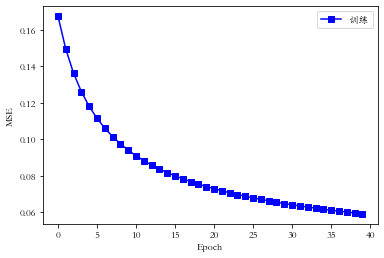

In [7]:
run(epochs=20)


In [ ]:
import os
pid=os.getpid()
!kill -9 $pid




In [ ]:
import os
pid=os.getpid()
!kill -9 $pid




In [ ]:
import os
pid=os.getpid()
!kill -9 $pid


